# EY Data Science Challange

Goal: Predict whether the last trajectory enter the area or not <br>
In this notebook, we only train the model with feature related to the **last instance**.
This will serve as our baseline.

In [1]:
import pandas as pd
train = pd.read_csv('data_train.csv')
test = pd.read_csv('data_test.csv')
# train = train[:5000]

# Data Preporcessing(instance-based)
By observing the distribution of the entry points, we can find that most points are located within a certain area. It is obvious that we can try to map this area and find if the entry point laid within this area.

In [2]:
# the target area
x_target = [3750901.5068,3770901.5068]
y_target  = [-19268905.6133,-19208905.6133]

from utility import create_response
train['in_area'] = create_response(train.x_exit,train.y_exit,x_target,y_target)
train.head()

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,in_area
0,0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,0
1,1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,0
2,2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,0
3,3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,0
4,4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,0


## Wrapper Method
Wrapper is an single instance classifier. This method labels all the instances in a bag with the same class. This assumses all the instances in a bag are the same class regardness their attributes.

After that single instance algorithm will learn and model the data. To classify new data, we will used the model to predict all the instances and use the standard MI assupmtion (if any instance in a bag positive, the bag will be positive)

As we are only interested on the last trajectory, instead of viewing each instance seperately, we will just use the label of the last trajectory and map it back to the previous instance.

In [3]:
map_ref = train.groupby('hash').last()['in_area'] #getting a series of the label of each bag
train['target'] = train.hash
train['target'] = train['target'].map(map_ref)
train.head()

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,in_area,target
0,0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,0,0
1,1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,0,0
2,2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,0,0
3,3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,0,0
4,4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,0,0


In [4]:
train.in_area.mean()

0.2986901022029764

In [5]:
# calculate the boundary of the area
x_1, x_2 = train[train.target==1].x_entry.quantile([.975, 0.025])
y_1, y_2= train[train.target==1].y_entry.quantile([.95,.05])

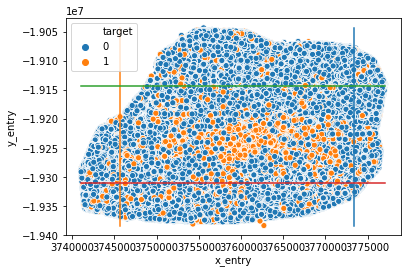

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(train.x_entry,train.y_entry,hue=train.target)
plt.plot([x_1,x_1],[train.y_entry.max(),train.y_entry.min()])
plt.plot([x_2,x_2],[train.y_entry.max(),train.y_entry.min()])
plt.plot([train.x_entry.max(),train.x_entry.min()],[y_1,y_1])
plt.plot([train.x_entry.max(),train.x_entry.min()],[y_2,y_2])
plt.show()

## Delta Time
We cacluated the differences between time_entry and time_exit to figure out how the long did the user travel

In [7]:
#calculate delta_time for the last trajectory
from utility import delta_t
train['delta_time'] = delta_t(train.time_entry,train.time_exit) #travel time of the last trajecotry
time_target = '15:00:00'
train['time_from_target'] = delta_t(train.time_entry,time_target)
train.head()

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,in_area,target,delta_time,time_from_target
0,0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,0,0,-241.0,-28529.0
1,1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,0,0,-308.0,-27566.0
2,2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,0,0,-593.0,-25588.0
3,3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,0,0,-1173.0,-24130.0
4,4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,0,0,0.0,-1311.0


# Euclidean Distance from Center
Calculating the distance between the entry point and the center of the target area.

In [8]:
# the target area
x_min,x_max = [3750901.5068,3770901.5068]
y_min,y_max  = [-19268905.6133,-19208905.6133]

# the center of target area
x_target = (x_max + x_min)/2
y_target = (y_max + y_min)/2

# calculate the euclidean 
from utility import eu_dist
train['dist_from_center'] = eu_dist(train.x_entry,train.y_entry,x_target,y_target)                                           
train.head()

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,in_area,target,delta_time,time_from_target,dist_from_center
0,0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,0,0,-241.0,-28529.0,145261.881023
1,1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,0,0,-308.0,-27566.0,85266.551966
2,2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,0,0,-593.0,-25588.0,56962.437581
3,3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,0,0,-1173.0,-24130.0,55736.470981
4,4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,0,0,0.0,-1311.0,49342.931074


In [10]:
# normalize the variables
columns = ['delta_time','time_from_target','dist_from_center']
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
train[columns] =  min_max_scaler.fit_transform(train[columns].values)
train.head()

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,in_area,target,delta_time,time_from_target,dist_from_center
0,0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,0,0,0.990194,0.442205,0.739870
1,1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,0,0,0.987468,0.458924,0.434215
2,2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,0,0,0.975872,0.493264,0.290016
3,3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,0,0,0.952272,0.518576,0.283770
4,4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,0,0,1.000000,0.914740,0.251197


In [11]:
X = train[columns]
y = train[['target']]
# to counter the imbalance problem, the whole bag need to be resample

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [13]:
y_test.mean()

target    0.286596
dtype: float64

## Model Training Process

In [14]:
# model training
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))

/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7917017187279326


In [15]:
from sklearn.neighbors import KNeighborsClassifier
# for k in range(85,95,1):
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
print(neigh.score(X_test,y_test))

/Users/garylau/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


0.7920640086458339


In [16]:
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier(hidden_layer_sizes=(10),random_state=121)
MLP.fit(X_train, y_train)
print(MLP.score(X_test,y_test))

/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7949070634252977


In [ ]:
from sklearn import tree
dtree = tree.DecisionTreeClassifier(max_depth=10)
dtree.fit(X_train, y_train)
print(dtree.score(X_test,y_test))

0.8053090824240265


In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state=0, tol=1e-5, gamma= 'scale')
svm.fit(X_train, y_train)

print(svm.score(X_test,y_test))

/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Ensembling Technique

In [ ]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_validate
dtree = tree.DecisionTreeClassifier()
bagging = BaggingClassifier(dtree,random_state=0)
bagging.fit(X_train, y_train)
print(bagging.score(X_test,y_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rtree = RandomForestClassifier(n_estimators=10,max_depth=5)
rtree.fit(X_train,y_train)
print(rtree.score(X_test,y_test))

In [ ]:
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[('logistic', clf), ('knn', neigh), ('mlp', MLP),('dtree',dtree),('svm',svm),('rtree',rtree)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
eclf1.score(X_test,y_test)

# Produce Result

The best result sof ar is using KNN.

In [ ]:
test['delta_time'] = delta_t(test.time_entry,test.time_exit)
test['dist_from_center'] = eu_dist(test.x_entry,test.y_entry,x_target,y_target)
time_target = '15:00:00'
test['time_from_target'] = delta_t(test.time_entry,time_target)
test[columns] =  min_max_scaler.fit_transform(test[columns].values)
test.head()

In [ ]:
X_result = test[columns]
# test['target'] = clf.predict(X_result)
# test['target'] = neigh.predict(X_result)
# test['target'] = dtree.predict(X_result)
# test['target'] = rtree.predict(X_result)
# test['target'] = bagging.predict(X_result)
# test['target'] = svm.predict(X_result)
test['target'] = eclf1.predict(X_result)
test.target.mean()

In [ ]:
# result = test[['hash','trajectory_id','target']]
bag_label = test[['hash','target']].groupby('hash').mean()['target']
bag_label = (bag_label>0.5).apply(int)
result = test[['hash','trajectory_id']].groupby('hash').last().reset_index()
result['target'] = result['hash'].map(bag_label)
result.head()

In [ ]:
result.target.mean()

In [ ]:
result = result[['trajectory_id','target']]
result.columns = ['id','target']
result.head()

In [ ]:
#write result as csv
result.to_csv('result.csv',sep=',')